In [1]:
#Import Libraries
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import itertools
import random
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.utils import shuffle
# import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = 'FinalData/train/'
test_path = 'FinalData/test/'

In [3]:
#Generate batches of images and apply VGG16's preprocessing function to the image
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=64,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=64, shuffle=True)

Found 4220 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.


In [4]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

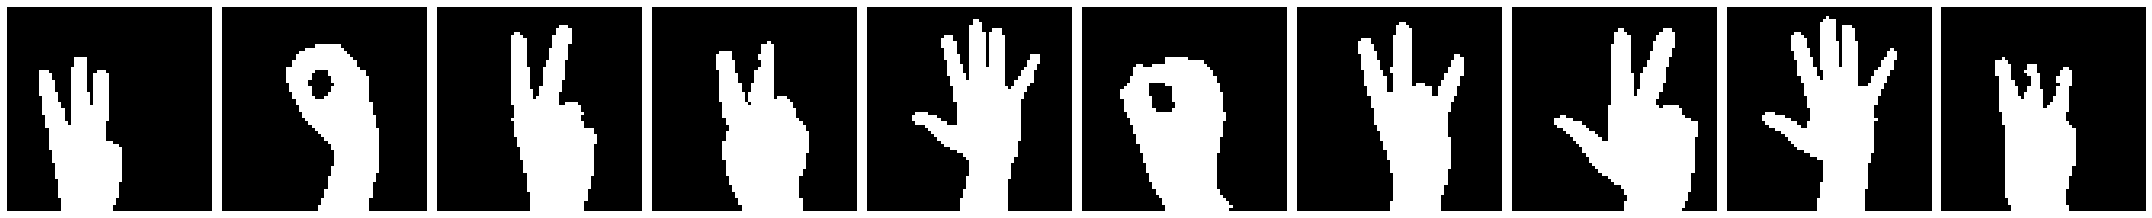

(64, 64, 64, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0

In [5]:
#Plot the images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

In [6]:
#Define the CNN model
model = Sequential()
#Add Convolutional Layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
#Flatten the layer
model.add(Flatten())
#Add dense and dropout layers
model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(10,activation ="softmax"))

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
#Fit the model
model.fit(train_batches, epochs=10, validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs
#Evaluate the score of the model on the training dataset
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/10
17/66 [======>.......................] - ETA: 6s - loss: 0.0124 - accuracy: 0.9972

KeyboardInterrupt: 

In [9]:
#Save the model
model.save('M5.h5')

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
model = keras.models.load_model("M5.h5")

In [11]:
#Evaluate the score of the model 
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 5.076511297374964e-05; accuracy of 100.0%


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [13]:
imgs, labels = next(test_batches)

In [14]:
#Define a dictionary mapping numbers from 0 to 9 to their names as strings
word_dict = {0:'Zero',1:'One',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

In [15]:
predictions = model.predict(imgs, verbose=0)

predictions on a small set of test data--

Seven   Six   Two   One   Eight   Five   Two   Eight   Six   Zero   Six   Seven   Nine   Eight   Two   Seven   Nine   Three   Four   Two   Zero   Eight   Two   Nine   Nine   One   One   Two   Zero   One   Four   One   Three   Six   Zero   Nine   One   Zero   Nine   Nine   Zero   Eight   Two   Zero   Three   Two   Three   Four   Three   Two   Three   Three   One   Nine   Two   Six   Three   Six   One   Zero   Eight   Zero   One   Eight   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

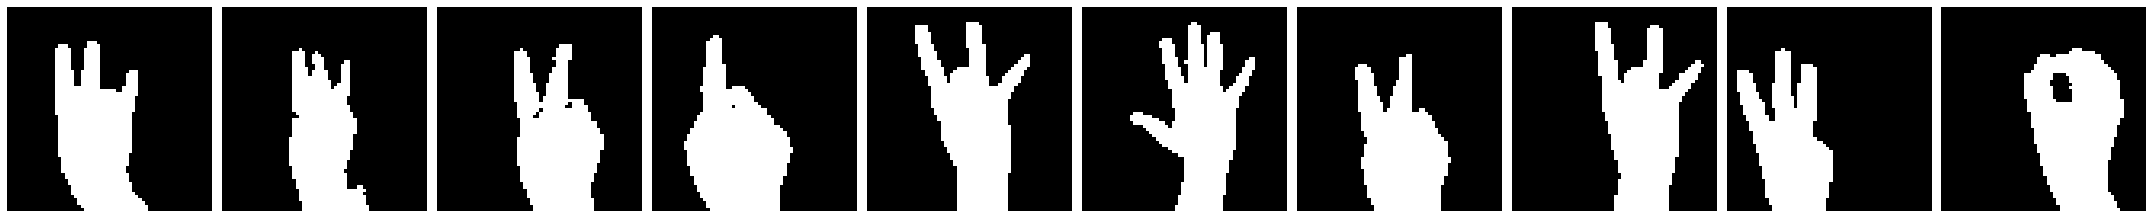

Actual labels
Seven   Six   Two   One   Eight   Five   Two   Eight   Six   Zero   Six   Seven   Nine   Eight   Two   Seven   Nine   Three   Four   Two   Zero   Eight   Two   Nine   Nine   One   One   Two   Zero   One   Four   One   Three   Six   Zero   Nine   One   Zero   Nine   Nine   Zero   Eight   Two   Zero   Three   Two   Three   Four   Three   Two   Three   Three   One   Nine   Two   Six   Three   Six   One   Zero   Eight   Zero   One   Eight   (64, 64, 64, 3)


In [16]:
predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
#Print the prediction which has the largest likelihood
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')
#Plot the images
plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

print(imgs.shape)

In [ ]:
# Visualize the model architecture
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)